# Libraries Used

In [1]:
from faker import Faker  
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tkinter as tk
from tkinter import simpledialog


# Generating Data

In [2]:
def generate_student_data(num_students):
    fake = Faker()
    data = []
    for _ in range(num_students):
        roll_no = fake.unique.random_int(min=1000, max=9999)  
        name = fake.name()
        batch = fake.random_int(min=2019, max=2023)      
        domain = random.choice(['Computer Science', 'Electrical Engineering', 'Artificial Intelligence', 'Business Analytics', 'Software Engineering'])  # Sample domains
        data.append({'Roll No': roll_no, 'Name': name, 'Batch': batch, 'Domain': domain})
    return data

def generate_faculty_data(num_faculty):
    fake = Faker()
    data = []
    for _ in range(num_faculty):
        fac_id = fake.unique.random_int(min=100, max=999)  
        name = fake.name()
        domain = random.choice(['Computer Science', 'Electrical Engineering', 'Artificial Intelligence', 'Business Analytics', 'Software Engineering'])  # Sample domains
        data.append({'Faculty ID': fac_id, 'Name': name, 'Domain': domain})
    return data

def generate_room_data(num_room):
    fake = Faker()
    data = []
    for _ in range(num_room):
        room_id = fake.unique.random_int(min=1, max=30)  
        capacity = random.choice([30, 35, 25])
        data.append({'Room ID': room_id,'Capacity': capacity})
    return data


# Writing the Randomly Generated Data into File using Pandas DataFrames

In [3]:
def writeRandomlyGeneratedData(students_data,faculty_data,room_data):
    directory = 'C:\\Users\\admin\\OneDrive\\Desktop\\AI Project'  # Specify the directory where you want to save the file

# Ensure that the directory exists, create it if it doesn't
    if not os.path.exists(directory):
        os.makedirs(directory)
    
#write the names of the files you want to create   
    filename1 = 'Stu_data.csv'
    filename2 = 'Fac_data.csv'
    filename3 = 'Room_data.csv'
    filename4 = 'Seating_Plan.csv' 
  
# Combine directory and filename to create the full paths
    full_path1 = directory + '\\' + filename1
    full_path2 = directory + '\\' + filename2
    full_path3 = directory + '\\' + filename3
    full_path4 = directory + '\\' + filename4

    header=['Roll No', 'Name', 'Batch', 'Domain']
    stu_data = pd.DataFrame(students_data, columns=header)  #write students data into file
    stu_data.to_csv(full_path1, index=False)

    header=['Faculty ID', 'Name', 'Domain']
    fac_data = pd.DataFrame(faculty_data, columns=header)  #write faculty data into file
    fac_data.to_csv(full_path2, index=False)

    header=['Room ID','Capacity']
    rm_data = pd.DataFrame(room_data, columns=header)  #write room data into file
    rm_data.to_csv(full_path3, index=False)
    
    return full_path1,full_path2,full_path3,full_path4

# Reading the Data from the above created files using Pandas

In [4]:
def readDataFromFiles(full_path1,full_path2,full_path3):
    stu_data = pd.read_csv(full_path1)  #student data
    fac_data = pd.read_csv(full_path2)  #faculty data
    room_data = pd.read_csv(full_path3) #room data
    return stu_data,fac_data,room_data

# Pre-Processing of the Data

In [5]:
def preProcessData(stu_data):
    stu_data = stu_data.dropna()

    label_encoder = LabelEncoder()  # Create a LabelEncoder object

    stu_data['Domain_LabelEncoded'] = label_encoder.fit_transform(stu_data['Domain'])  # Apply Label Encoding to a categorical column "Domain"-(0,1,2,3,4)

    features = stu_data.groupby(['Domain_LabelEncoded', 'Batch']).size().reset_index(name='Num_Students')  #featuring/grouping the data for "No.of students" from each domain and batch
    
    return stu_data,features


# Using Elbow Method For optimal no. of clusters

In [6]:
def elbowMethod(features):
#using elbow method
    wcss = []
    for i in range(1, 11):
        k_means = KMeans(n_clusters=i, n_init="auto")
        k_means.fit(features[['Domain_LabelEncoded','Batch']])  #Determine the optimal number of clusters based on domain and batch distribution
        wcss.append(k_means.inertia_)
        
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squared Distances')
    plt.show()

# Making Clusters based on the optimal no. of clusters from Elbow Method

In [7]:

def makeOptimalClusters(features,optimal_k=4):
    kmeans = KMeans(n_clusters=optimal_k)
    kmeans.fit(features[['Domain_LabelEncoded','Batch']])

# Get cluster labels and centroids
    cluster_labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
# Add cluster labels to the features DataFrame
    features['Cluster_Labels'] = cluster_labels 
    
    point_size = 15
    colors = ['red', 'green', 'blue', 'yellow'] 
    print("x are centroids")
    for i in range(optimal_k):
        print(f'Cluster {i}: {colors[i]}')    
    print("\n",features)

# Plot centroids
    for cluster_label in range(optimal_k):
        cluster_centroid = centroids[cluster_label]
        plt.scatter(cluster_centroid[0], cluster_centroid[1], color=colors[cluster_label], marker='x')

# Plot each cluster
    for cluster_label in range(optimal_k): 
        cluster_points = features[features['Cluster_Labels'] == cluster_label]
        for index, row in cluster_points.iterrows():
            plt.scatter(row['Domain_LabelEncoded'], row['Batch'], c=colors[cluster_label])

    plt.xlabel('Domain Label Encoded')
    plt.ylabel('Batch')
    plt.title('K-Means Clustering')
    plt.show()
    return  features


# Assigning Each student to their respective Clusters

In [8]:
def assignClustersToStudents(stu_data,features):
    for index, row in features.iterrows():
        domain_label = row['Domain_LabelEncoded']
        batch = row['Batch']
        cluster_label = row['Cluster_Labels']
    
    # Filter students DataFrame based on domain label and batch
        filtered_students = stu_data[(stu_data['Domain_LabelEncoded'] == domain_label) & (stu_data['Batch'] == batch)]
    
    # Update the cluster label for filtered students
        stu_data.loc[filtered_students.index, 'Cluster_Labels'] = cluster_label
        
    return stu_data


# Asking For the Courses (Batchwise) to generate seating plan

In [9]:
# courses = {}

# # Loop to collect course names for each batch and domain combination
# for year in range(2019, 2024):
#     for domain in ['Artificial Intelligence', 'Business Analytics', 'Software Engineering', 'Computer Science', 'Electrical Engineering']:
#         course_name = input("Enter the course name for Batch-" + str(year) + "-" + domain + ": ")
#         courses[(year, domain)] = course_name

def addCourseInfo(stu_data):
    courses = {
        (2019, 'Artificial Intelligence'): 'Linear Algebra',
        (2019, 'Business Analytics'): 'Statistics',
        (2019, 'Software Engineering'): 'Software Design',
        (2019, 'Computer Science'): 'Operating Systems',
        (2019, 'Electrical Engineering'): 'Digital Logic Design',
        (2020, 'Artificial Intelligence'): 'Probability',
        (2020, 'Business Analytics'): 'Business Maths',
        (2020, 'Software Engineering'): 'Statistics',
        (2020, 'Computer Science'): 'Theory of Automata',
        (2020, 'Electrical Engineering'): 'Signals',
        (2021, 'Artificial Intelligence'): 'Graph Theory',
        (2021, 'Business Analytics'): 'Marketing',
        (2021, 'Software Engineering'): 'Entrepreneurship',
        (2021, 'Computer Science'): 'Algorithms',
        (2021, 'Electrical Engineering'): 'Circuits',
        (2022, 'Artificial Intelligence'): 'Marketing',
        (2022, 'Business Analytics'): 'Theory of Automata',
        (2022, 'Software Engineering'): 'Database Systems',
        (2022, 'Computer Science'): 'Gaming',
        (2022, 'Electrical Engineering'): 'Web Development',
        (2023, 'Artificial Intelligence'): 'Calculus',
        (2023, 'Business Analytics'): 'Strategies',
        (2023, 'Software Engineering'): 'Documentation',
        (2023, 'Computer Science'): 'Web Development',
        (2023, 'Electrical Engineering'): 'Statistics'
    }
    stu_data['Course'] = ""   # Add 'Course' column to student data
    for index, row in stu_data.iterrows():   # Update student data with the course information
        batch = row['Batch']
        domain = row['Domain']
        for key, value in courses.items():
            if key == (batch, domain):
                stu_data.at[index, 'Course'] = value
                break
        else:
            stu_data.at[index, 'Course'] = "Unknown"
            
    return stu_data

# Assigning Rooms To the Students While keeping the optimization in view

In [10]:
def morning_rooms_assigned(students, rooms):
    students = students.copy()
    rooms = rooms.copy()
    # Add columns to students DataFrame
    students['Assigned_Room'] = ""  
    students['Timing'] = ""  
    
    assigned_rooms = {}  
    for cluster_label in students['Cluster_Labels'].unique():  # Iterate over unique cluster labels
        cluster_students = students[students['Cluster_Labels'] == cluster_label]  # Filter students by cluster
        
        for domain_label in cluster_students['Domain_LabelEncoded'].unique():  # Iterate over unique domain labels within the cluster
            domain_students = cluster_students[cluster_students['Domain_LabelEncoded'] == domain_label]  # Filter students by domain
            
            for _, student in domain_students.iterrows():
                available_rooms = rooms[rooms['Capacity'] > 0]              # Filter rooms by capacity
                
                if not available_rooms.empty:                  # Sort available rooms by capacity (ascending) to optimize seating arrangements
                    available_rooms = available_rooms.sort_values(by='Capacity')
                    
                    # Assign the student to the room with the lowest remaining capacity so gradually the rooms will get filled
                    assigned_room = available_rooms.iloc[0]  
                    room_id = assigned_room['Room ID']
                    
                    # Update student's Assigned_Room and Timing
                    students.loc[students['Roll No'] == student['Roll No'], 'Assigned_Room'] = room_id
                    students.loc[students['Roll No'] == student['Roll No'], 'Timing'] = 'Morning'

                    # Decrement the room capacity
                    rooms.loc[rooms['Room ID'] == room_id, 'Capacity'] -= 1
                else:
                    # If no room is available, update Assigned_Room to False and Timing to 'Not Assigned'
                    students.loc[students['Roll No'] == student['Roll No'], 'Assigned_Room'] = False
                    students.loc[students['Roll No'] == student['Roll No'], 'Timing'] = 'Not Assigned'
                
    return students


In [11]:
def afterNoon_room_assigned(students, rooms):
    students = students.copy()
    rooms = rooms.copy()
    
    # Filter students who were not assigned rooms during the morning session
    unassigned_students = students[(students['Assigned_Room'] == False) & (students['Timing'] == 'Not Assigned')]
    
    # Iterate over clusters
    for cluster_label in unassigned_students['Cluster_Labels'].unique():
        cluster_students = unassigned_students[unassigned_students['Cluster_Labels'] == cluster_label] 
        
        # Within each cluster, iterate over unique domain labels
        for domain_label in cluster_students['Domain_LabelEncoded'].unique():
            domain_students = cluster_students[cluster_students['Domain_LabelEncoded'] == domain_label]  # Filter students by domain
            
            for _, student in domain_students.iterrows():
                available_rooms = rooms[rooms['Capacity'] > 0]  # Filter rooms by capacity
                
                if not available_rooms.empty:                  # Sort available rooms by capacity (ascending) to optimize seating arrangements
                    available_rooms = available_rooms.sort_values(by='Capacity')
                    
                    # Assign the student to the room with the lowest remaining capacity so gradually the rooms will get filled
                    assigned_room = available_rooms.iloc[0]  
                    room_id = assigned_room['Room ID']
                    
                    # Update student's Assigned_Room and Timing
                    students.loc[students['Roll No'] == student['Roll No'], 'Assigned_Room'] = room_id
                    students.loc[students['Roll No'] == student['Roll No'], 'Timing'] = 'After Noon'

                    # Decrement the room capacity
                    rooms.loc[rooms['Room ID'] == room_id, 'Capacity'] -= 1
                else:
                    # If no room is available, update Assigned_Room to False and Timing to 'Not Assigned'
                    students.loc[students['Roll No'] == student['Roll No'], 'Assigned_Room'] = False
                    students.loc[students['Roll No'] == student['Roll No'], 'Timing'] = 'Not Assigned'
                
            
    return students  # Return the modified DataFrame


In [12]:
def evening_room_assigned(students, rooms):
    students = students.copy()
    rooms = rooms.copy()
    unassigned_students = students[(students['Assigned_Room'] == False) & (students['Timing'] == 'Not Assigned')]      # Filter students who were not assigned rooms during the morning session    
    # Iterate over clusters
    for cluster_label in unassigned_students['Cluster_Labels'].unique():
        cluster_students = unassigned_students[unassigned_students['Cluster_Labels'] == cluster_label]         
        # Within each cluster, iterate over unique domain labels
        for domain_label in cluster_students['Domain_LabelEncoded'].unique():
            domain_students = cluster_students[cluster_students['Domain_LabelEncoded'] == domain_label]  # Filter students by domain
            
            for _, student in domain_students.iterrows():
                available_rooms = rooms[rooms['Capacity'] > 0]  # Filter rooms by capacity
                
                if not available_rooms.empty:                  # Sort available rooms by capacity (ascending) to optimize seating arrangements
                    available_rooms = available_rooms.sort_values(by='Capacity')
                    
                    # Assign the student to the room with the lowest remaining capacity so gradually the rooms will get filled
                    assigned_room = available_rooms.iloc[0]  
                    room_id = assigned_room['Room ID']
                    
                    # Update student's Assigned_Room and Timing
                    students.loc[students['Roll No'] == student['Roll No'], 'Assigned_Room'] = room_id
                    students.loc[students['Roll No'] == student['Roll No'], 'Timing'] = 'Evening'

                    rooms.loc[rooms['Room ID'] == room_id, 'Capacity'] -= 1                      # Decrement the room capacity
                else:
                    # If no room is available, update Assigned_Room to False and Timing to 'Not Assigned'
                    students.loc[students['Roll No'] == student['Roll No'], 'Assigned_Room'] = False
                    students.loc[students['Roll No'] == student['Roll No'], 'Timing'] = 'Not Assigned'
                
            
    return students  # Return the modified DataFrame


In [13]:
# First, assign morning rooms
def StudentsRoomAssignment(stu_data,room_data):
    assigned_students_morning = morning_rooms_assigned(stu_data, room_data)
   
# Then, assign after-noon rooms for unassigned students
    assigned_students_afterNoon = afterNoon_room_assigned(assigned_students_morning, room_data)

# Then, assign evening rooms for unassigned students
    assigned_students_evening = evening_room_assigned(assigned_students_afterNoon, room_data)
    
    return assigned_students_morning,assigned_students_afterNoon,assigned_students_evening


Generating Seating Plan for Students 

In [14]:
def seatingPlanForStudents(assigned_students_evening,filename4):
    seating_plan = pd.DataFrame({
        'Roll No': assigned_students_evening['Roll No'],
        'Name': assigned_students_evening['Name'],
        'Domain': assigned_students_evening['Domain'],
        'Batch': assigned_students_evening['Batch'],
        'Course': assigned_students_evening['Course'],
        'Assigned_Room': assigned_students_evening['Assigned_Room'],
        'Timing': assigned_students_evening['Timing'],
    })
    seating_plan.to_csv(filename4, index=False)

# Assigning Faculty to the rooms keeping in view the related domains 


In [15]:
def assign_faculty_to_rooms(room_data, faculty_data, allocated_faculty):
    room_faculty = set()
    unique_domains = room_data['Domain'].unique()  # Get unique domains present in the room

    for domain in unique_domains:  # Iterate over unique domains in the room
        faculty_assigned = False  # Flag to check if faculty for domain has been assigned
        
        for _, fac_info in faculty_data.iterrows():  # Iterate over faculty data
            if fac_info['Domain'] == domain:
                faculty_id = fac_info['Faculty ID']
                
                # Check if any faculty is already assigned for this room and timing
                if (room_data['Assigned_Room'].iloc[0], room_data['Timing'].iloc[0]) in allocated_faculty.values():
                    continue  # Skip if any faculty is already assigned to this room and timing
                
                # Check if faculty is already assigned to another room at the same timing
                if faculty_id in allocated_faculty.values():
                    continue  # Skip this faculty if already assigned to another room at the same timing
                
                room_faculty.add(faculty_id)
                
                # Assign faculty to the room and timing
                allocated_faculty[(room_data['Assigned_Room'].iloc[0], room_data['Timing'].iloc[0], domain)] = faculty_id
                faculty_assigned = True
                break

        if not faculty_assigned:
            print(f"No faculty member found for domain {domain} in room {room_data['Assigned_Room'].iloc[0]}")

    return allocated_faculty  # Return the modified allocated_faculty dictionary

In [16]:
def seatingPlanForFaculty(fac_data):
    seating_plan_df = pd.read_csv("Seating_Plan.csv")

#(i'll use this to check same faculty members should not be assigned to differnet rooms in same time slot)

    morning_rooms_grouped = seating_plan_df[seating_plan_df['Timing'] == 'Morning'].groupby('Assigned_Room')

    afternoon_rooms_grouped = seating_plan_df[seating_plan_df['Timing'] == 'After Noon'].groupby('Assigned_Room')

    evening_rooms_grouped = seating_plan_df[seating_plan_df['Timing'] == 'Evening'].groupby('Assigned_Room')

# Initialize allocated_faculty dictionary
    allocated_faculty = {}

# Assign faculty for morning sessions 
    for room_id, room_data in morning_rooms_grouped:
        allocated_faculty = assign_faculty_to_rooms(room_data, fac_data, allocated_faculty)

# Assign faculty for afternoon sessions
    for room_id, room_data in afternoon_rooms_grouped:
        allocated_faculty = assign_faculty_to_rooms(room_data, fac_data, allocated_faculty)
    
# Assign faculty for evening sessions
    for room_id, room_data in evening_rooms_grouped:
        allocated_faculty = assign_faculty_to_rooms(room_data, fac_data, allocated_faculty)
    
    return allocated_faculty

In [17]:
def generateFacultyPlan(allocated_faculty):
# Convert allocated_faculty dictionary to a list of tuples
    assigned_faculty_data = [(room_info[0], room_info[1], room_info[2], faculty_id) for room_info, faculty_id in allocated_faculty.items()]

# Create DataFrame from the list of tuples
    assigned_faculty_df = pd.DataFrame(assigned_faculty_data, columns=['Room_ID', 'Timing', 'Domain', 'Faculty_ID'])

# Save the DataFrame to a CSV file
    assigned_faculty_df.to_csv('faculty_assignments.csv', index=False)



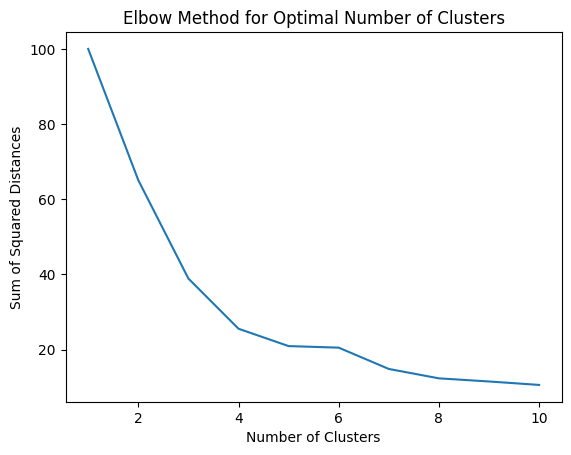

x are centroids
Cluster 0: red
Cluster 1: green
Cluster 2: blue
Cluster 3: yellow

     Domain_LabelEncoded  Batch  Num_Students  Cluster_Labels
0                     0   2019           109               0
1                     0   2020            98               0
2                     0   2021           106               0
3                     0   2022            81               1
4                     0   2023           103               1
5                     1   2019           100               0
6                     1   2020            87               0
7                     1   2021           103               0
8                     1   2022            93               1
9                     1   2023            95               1
10                    2   2019           108               2
11                    2   2020            91               2
12                    2   2021           106               2
13                    2   2022           105               1
1

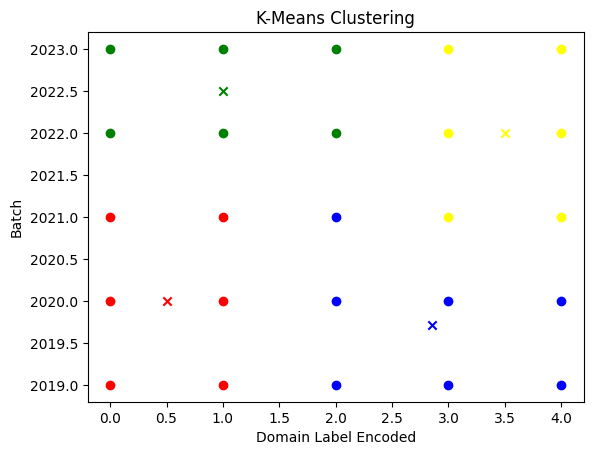

In [18]:
if __name__ == "__main__":
    ROOT = tk.Tk()
    ROOT.withdraw()
    # the input dialog
    STUDENT_INP = simpledialog.askinteger(title="Students", prompt="How many students need to be accommodated?:")
    FACULTY_INP = simpledialog.askinteger(title="Faculty", prompt="How many Faculty members are available?:")
    students_data=generate_student_data(STUDENT_INP)  #2500
    faculty_data=generate_faculty_data(FACULTY_INP) #200
    room_data=generate_room_data(30)
    full_path1,full_path2,full_path3,full_path4=writeRandomlyGeneratedData(students_data,faculty_data,room_data)
    stu_data,fac_data,room_data=readDataFromFiles(full_path1,full_path2,full_path3)
    stu_data,features=preProcessData(stu_data)
    elbowMethod(features)
    optimal_k = simpledialog.askinteger(title="Students", prompt="What is the optimal value for k?:")
    features=makeOptimalClusters(features,optimal_k)
    stu_data=assignClustersToStudents(stu_data,features)
    stu_data=addCourseInfo(stu_data)
    assigned_students_morning,assigned_students_afterNoon,assigned_students_evening=StudentsRoomAssignment(stu_data,room_data)
    seatingPlanForStudents(assigned_students_evening,full_path4)
    allocated_faculty=seatingPlanForFaculty(fac_data)
    generateFacultyPlan(allocated_faculty)
